In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from skimage.measure import ransac
from skimage.transform import AffineTransform, ProjectiveTransform, warp
from skimage.feature import match_descriptors
from skimage import draw 
import matplotlib.patches as patches


In [2]:

def apply_2d_homography(point,h):
    x,y=point
    vec=np.array([x,y,1])
    res = h@vec
    res = res / res[-1]
    return res[:2]

def Metrics(kp1, desc1, kp2, desc2, ResidualThreshold=3, max_trials=3000, transformation=ProjectiveTransform , ground_truth_transformation=None):
#     print(type(desc1), type(desc2))
    matches12 = match_descriptors(desc1, desc2, cross_check=True)
    matches21 = match_descriptors(desc2, desc1, cross_check=True)
    if isinstance(kp1[0], cv2.KeyPoint) and isinstance(kp2[0], cv2.KeyPoint):
        points = pt1 = np.array([kp1[m].pt for m, _ in matches12])
        pt2 = np.array([kp2[n].pt for _, n in matches12])
    else:
        points = pt1 = np.array([kp1[m] for m, _ in matches12])
        pt2 = np.array([kp2[n] for _, n in matches12])
        kp1 = cv2.KeyPoint_convert(kp1)
        kp2 = cv2.KeyPoint_convert(kp2)

    forward_transformation, inliers = ransac(
    (pt1, pt2),
    transformation, min_samples=3,
    residual_threshold=ResidualThreshold,  max_trials=max_trials,
    )
    if isinstance(kp1[0], cv2.KeyPoint) and isinstance(kp2[0], cv2.KeyPoint):
        pt1 = np.array([kp1[n].pt for _, n in matches21])
        pt2 = np.array([kp2[m].pt for m, _ in matches21])
    else:
        pt1 = np.array([kp1[m] for _, n in matches12])
        pt2 = np.array([kp2[n] for m, _ in matches12])
        kp1 = cv2.KeyPoint_convert(kp1)
        kp2 = cv2.KeyPoint_convert(kp2)
    
    backward_transformation, _ = ransac(
    (pt2, pt1),
    transformation, min_samples=3,
    residual_threshold=ResidualThreshold, max_trials=max_trials,
    )
    
    Transform = backward_transformation.params @ forward_transformation.params
    dist_all = 0
    for pt in points:
        predicted_pt = apply_2d_homography(pt,Transform)
        dist_all += np.sum((predicted_pt - pt)**2)
        
    dist_matching_error = 0
    if ground_truth_transformation is not None:
        for pt in points:
            predicted_pt = apply_2d_homography(pt,forward_transformation.params)
            ground_truth_pt = apply_2d_homography(pt, ground_truth_transformation)
            dist_matching_error += np.sum((predicted_pt - ground_truth_pt)**2)**.5

            
    
    N_all = len(matches12)
    N_red = np.sum(inliers)
    rocc = N_red / N_all
    rmse_all = np.sqrt(dist_all/len(points))
    if ground_truth_transformation is not None:
        matching_error = dist_matching_error/len(points)
    else:
        matching_error = -1
        
    kps =  kp1, kp2
    matches = [cv2.DMatch(_queryIdx=m ,_trainIdx=n, _imgIdx=0, _distance=0 ) for m, n in matches12[inliers]]
    return N_red, N_all, rocc, rmse_all, forward_transformation.params, kps, matches, matching_error

In [3]:
def homographyAddTranslation(h, translation):
    h_t = np.eye(3)
    h_t[0, 2] = translation[1]
    h_t[1, 2] = translation[0]
    return h_t @ h

def crop_image(img,percentile=.6):
    height,width=img.shape[:2]
    h=int(percentile*height/2)
    w=int(percentile*width/2)
    return img[h:-h,w:-w]

def build_checkerboard(size,grid_size):
    height, width = size
    ones = np.ones((grid_size, grid_size))
    zeros = np.zeros((grid_size, grid_size))
    x1 = np.concatenate((ones, zeros), axis=1)
    x2 = np.concatenate((zeros, ones), axis=1)
    x = np.concatenate((x1, x2), axis=0)
    
    n_h = int(height/grid_size/2) +1
    n_w = int(width/grid_size/2) + 1
    board = np.tile(x,(n_h, n_w)).astype('bool')
    
    return board[:height,:width]


def stichImages(img1, img2, h, grid_size=64, inverse=False):
    dst_h, dst_w = img2.shape[:2]
    dst_shape = (dst_w * 3, dst_h * 3)
    h = homographyAddTranslation(h, (dst_h, dst_w))
    transfromed_img1 = cv2.warpPerspective(img1, h, dst_shape)
    transformed_img2 = np.pad(img2, [[dst_h, dst_h], [dst_w, dst_w]])
    mask = build_checkerboard(dst_shape, grid_size)
    if inverse:
        img_registeded = np.where(mask.T, transfromed_img1, transformed_img2)
    else:
        img_registeded = np.where(mask.T, transformed_img2, transfromed_img1)
    img_registeded = crop_image(img_registeded)
    plt.figure(figsize=(14, 10))
    plt.imshow(img_registeded)
    plt.show()
    return 

In [4]:
# img1 = cv2.imread("../../testdata/input_0.png")
# img2 = cv2.imread("../../testdata/input_1.png")

# img1 = cv2.imread("../../testdata/a1.jpg")
# img2 = cv2.imread("../../testdata/a2.jpg")

img1 = cv2.imread("../../testdata/k1.jpg")
img2 = cv2.imread("../../testdata/k2.jpg")


# img1 = cv2.imread("../../testdata/4.ppm")
# img2 = cv2.imread("../../testdata/3.ppm")

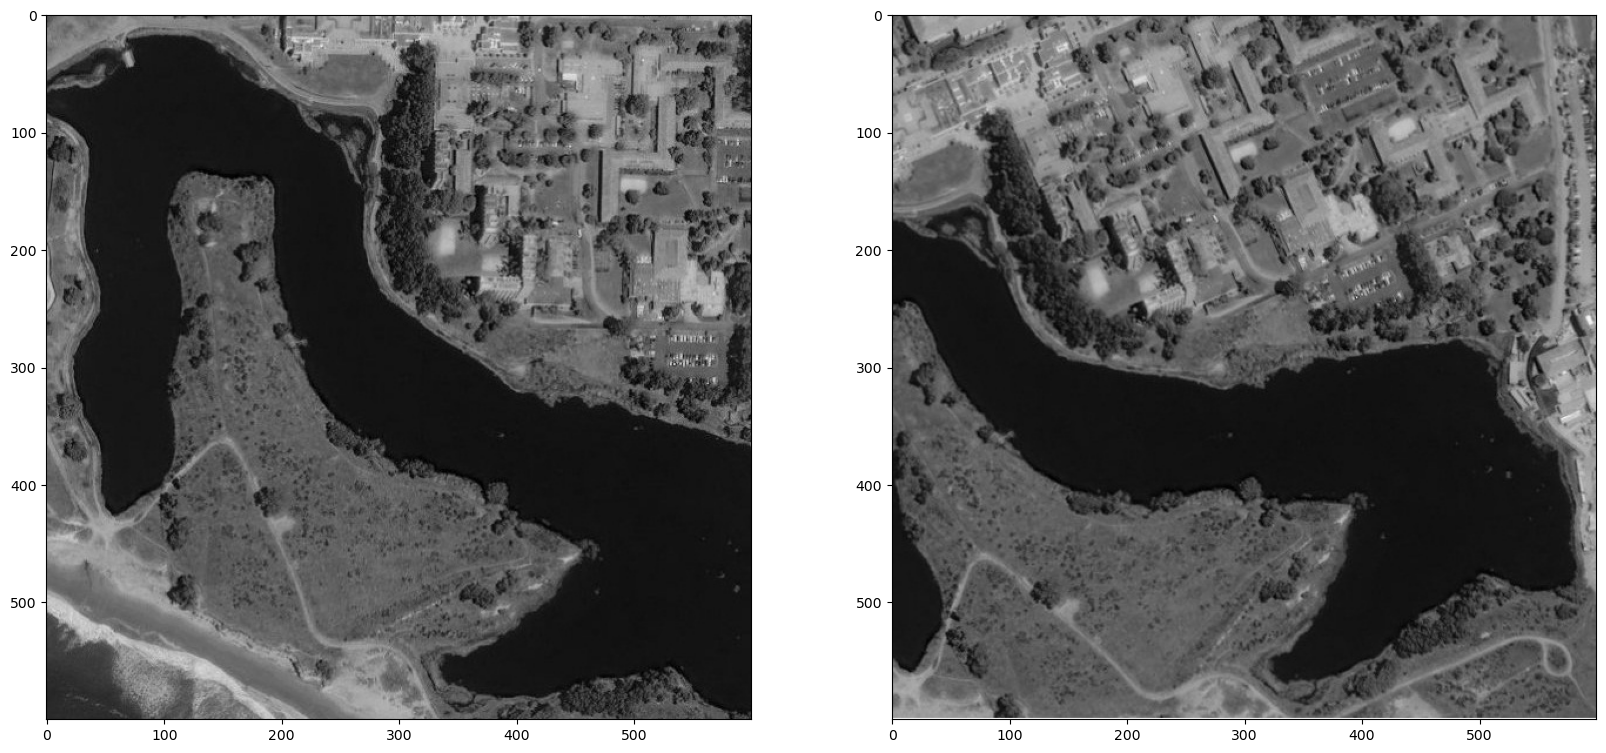

In [5]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].imshow(img1)
ax[1].imshow(img2)

In [6]:
scaling_factor = .3

In [7]:
img1_coarse = cv2.resize(img1, (0, 0), fx=scaling_factor, fy=scaling_factor)
img2_coarse = cv2.resize(img2, (0, 0), fx=scaling_factor, fy=scaling_factor)

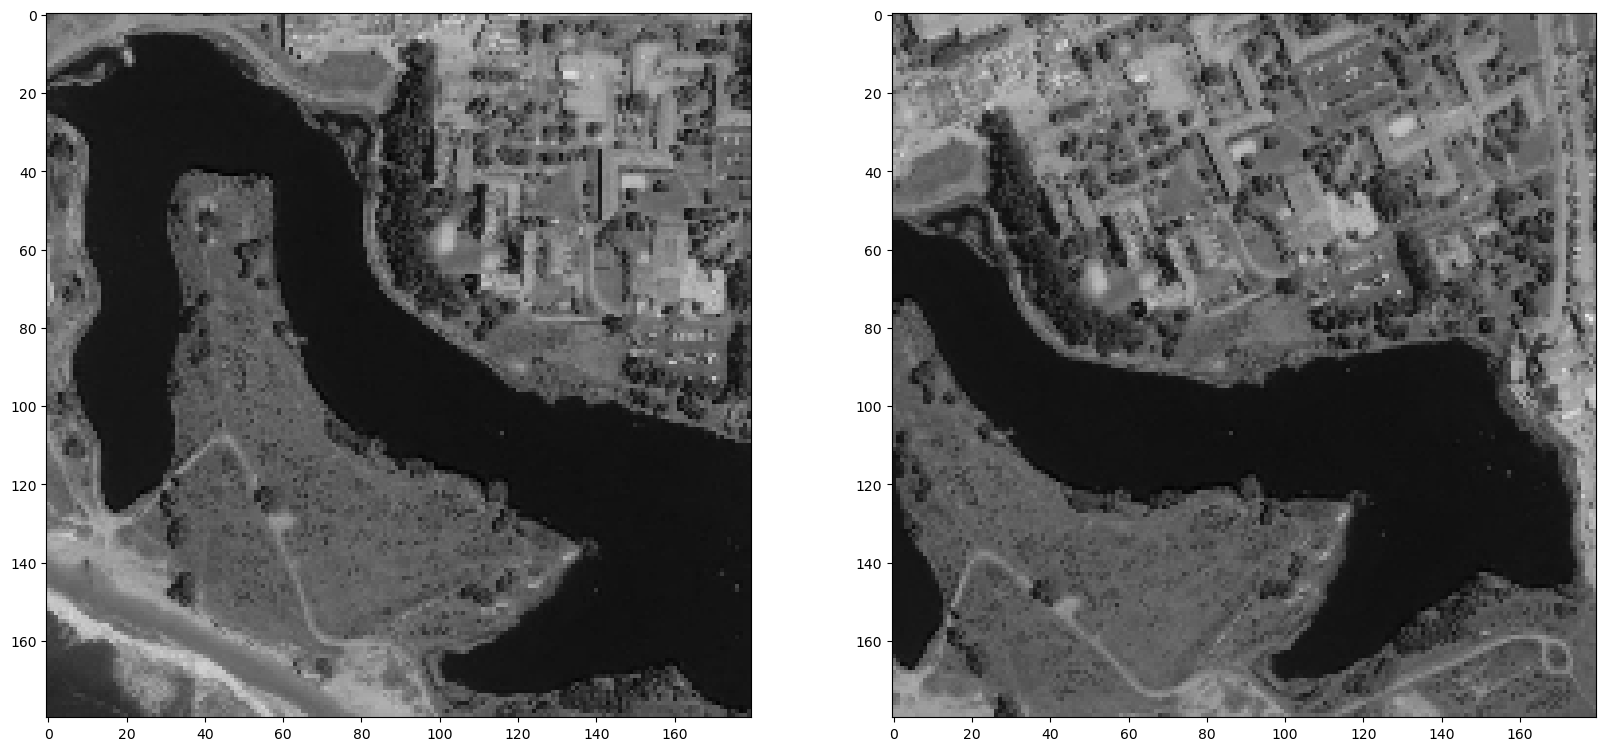

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].imshow(img1_coarse)
ax[1].imshow(img2_coarse)

In [9]:
featDet = cv2.BRISK_create()

In [10]:
open_cv_kp1, desc1 = featDet.detectAndCompute(img1_coarse, None)
open_cv_kp2, desc2 = featDet.detectAndCompute(img2_coarse, None)

In [11]:
kp1 = np.array([k.pt for k in open_cv_kp1])
kp2 = np.array([k.pt for k in open_cv_kp2])

In [12]:
matches = match_descriptors(desc1, desc2)

In [13]:
transform, inliers = ransac(data=(kp1[matches[:, 0]], kp2[matches[:, 1]]),
                            model_class=AffineTransform, min_samples=3,
                            residual_threshold=10, max_trials=5000)

In [14]:
coarse_homography = AffineTransform(scale=scaling_factor**-1).params @ transform.params @ AffineTransform(scale=scaling_factor).params

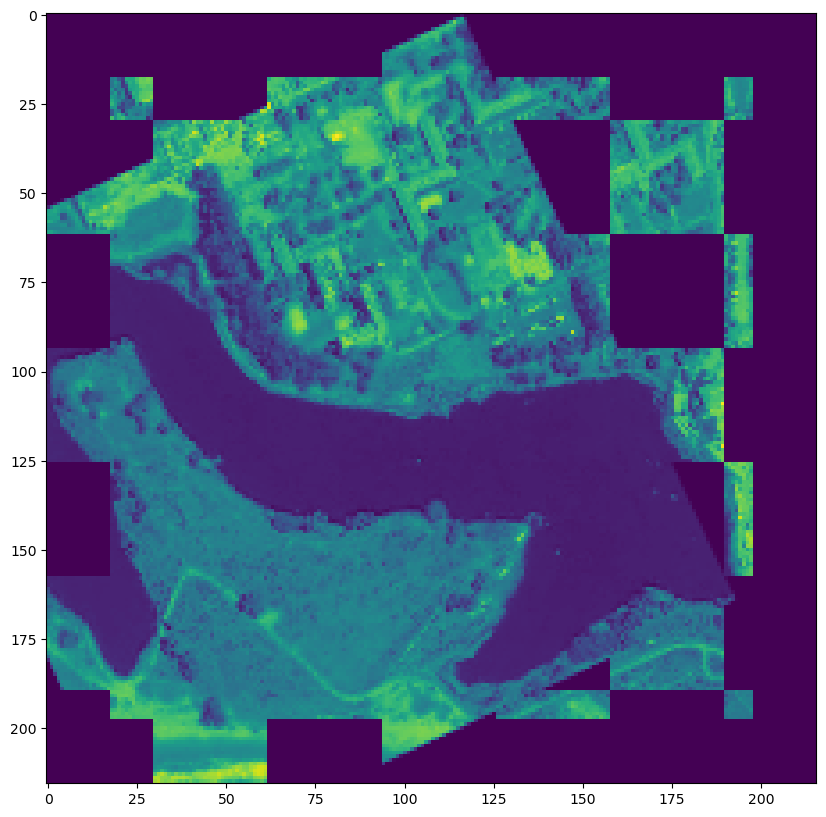

In [15]:
stichImages(img1_coarse[..., 0], img2_coarse[..., 0], transform.params, 32)

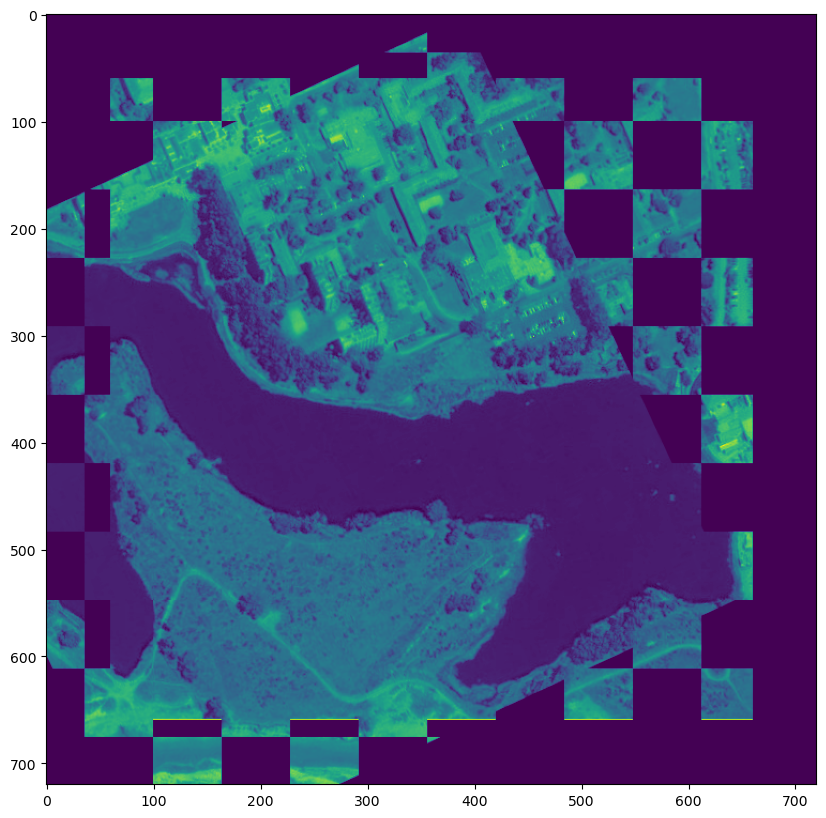

In [16]:
stichImages(img1[..., 0], img2[..., 0], coarse_homography)

In [17]:
def get_non_overlapping_rectangles(mask,  width=50, n_patches=3, verbose=False):

    m, n = np.argwhere(mask).T
    top_left_m, top_left_n = m.min(), n.min()
    button_left_m, button_left_n = m.max(), n.max()
    mask_height, mask_width = mask.shape[:2]
    m_vector = np.arange(top_left_m , button_left_m , width)
    n_vector = np.arange(top_left_n  , button_left_n , width)

    m, n = np.meshgrid(m_vector, n_vector)

    all_locs = [(m, n) for m, n in zip(m.flatten(), n.flatten())]
    filtered_all_locs = []
    for m, n in all_locs:
        if m-width//2 > 0 and  n-width//2> 0 and m+width//2 < mask_height and n+width < mask_width:
            if mask[m-width//2, n-width//2] and mask[m+width//2, n+width//2] and mask[m-width//2, n+width//2 ] and \
                mask[m+width//2, n-width//2] : 
                filtered_all_locs.append((m, n))
            
        
        
    all_locs = np.array(filtered_all_locs)
    np.random.shuffle(filtered_all_locs)
    plane_map = np.zeros_like(mask)
    selected_locs = filtered_all_locs[:n_patches]
    if verbose:
        for m, n in selected_locs:
            ms, ns = draw.rectangle((m-width//2, n-width//2), (m+width//2, n+width//2), shape=mask.shape[:2])
            plt.scatter(n, m)
            plane_map[ms, ns]  = 1

        plt.imshow(plane_map*mask)
        plt.imshow(mask, alpha=.5)
        plt.show()

    return selected_locs

In [18]:
def patch_based_key_point_extraction(img1, img2, feat_extractor, transformation_mat, n_patches=5, patch_width=50 ):
    mask = np.ones_like(img2)[..., 0]
    border = 10 
    
    helper_mask = np.zeros_like(mask)
    helper_mask[border: -border, border: -border] = 1
    coarse_tr = ProjectiveTransform(transformation_mat)
    mask_img2 = helper_mask * mask

    mask_img1 = warp(mask_img2, coarse_tr, preserve_range=True)
   
    mask_img1 = mask_img1 * helper_mask
    mask_img2 = warp(mask_img1, coarse_tr.inverse, preserve_range=True)
    # plt.imshow(mask_img2)
    # plt.show()
    # plt.imshow(mask_img1)
    # plt.show()
    patch_locs = get_non_overlapping_rectangles(mask_img1, patch_width, n_patches, verbose=True)
    kp1, desc1 = [], []
    kp2, desc2 = [], []
    
    fig, ax = plt.subplots(1, 2, figsize=(20, 10))
    ax[0].imshow(img1)
    ax[0].imshow(mask_img1, alpha=.5)
    ax[1].imshow(img2)
    ax[1].imshow(mask_img2, alpha=.5)
    for n, m in patch_locs:
        ms = m - patch_width//2
        ns = n -patch_width//2
        me = m + patch_width//2
        ne = n + patch_width//2
        ax[0].scatter(m, n)
        rect = patches.Rectangle((ms, ns), patch_width, patch_width, linewidth=1, edgecolor='r', facecolor='none')
        ax[0].add_patch(rect)
        patch1 = img1[ns:ne, ms:me]
        kp_img_1, desc_img_1 = feat_extractor.detectAndCompute(patch1, None)
        if desc_img_1 is None :continue
        desc1.extend(desc_img_1)
        for kp in kp_img_1:
            kp.pt = (kp.pt[0] + ms, kp.pt[1] + ns)
            # kp.pt = (kp.pt[0] + ns, kp.pt[1] + ms)
            kp1.append(kp)
        
        
        
        tr_m, tr_n = apply_2d_homography((m, n), transformation_mat)
        tr_me, tr_ne = apply_2d_homography((me, ne), transformation_mat)
        tr_width = ((tr_m - tr_me)**2 + (tr_n - tr_ne)**2)**.5/2**.5*2
        
   
        ax[1].scatter(tr_m, tr_n)
        tr_m_s = int(tr_m - tr_width // 2)
        tr_n_s = int(tr_n - tr_width // 2)
        tr_m_e = int(tr_m + tr_width // 2)
        tr_n_e = int(tr_n + tr_width // 2)
        rect = patches.Rectangle((tr_m_s, tr_n_s), tr_width, tr_width, linewidth=1, edgecolor='r', facecolor='none')
        ax[1].add_patch(rect)

        patch2 = img2[tr_n_s: tr_n_e, tr_m_s: tr_m_e]
        kp_img_2, desc_img_2 = feat_extractor.detectAndCompute(patch2, None)
        if  desc_img_2 is None :continue
        desc2.extend(desc_img_2)
        for kp in kp_img_2:
            kp.pt = (kp.pt[0] + tr_m_s, kp.pt[1] + tr_n_s)
            # kp.pt = (kp.pt[0] + tr_n_s, kp.pt[1] + tr_m_s)
            
            kp2.append(kp)
        
        # fig2, ax2 = plt.subplots(1, 2)
        # ax2[0].imshow(patch1)
        # ax2[1].imshow(patch2)

    return kp1, desc1, kp2, desc2

        
       
    

In [19]:
featDet = cv2.BRISK_create()

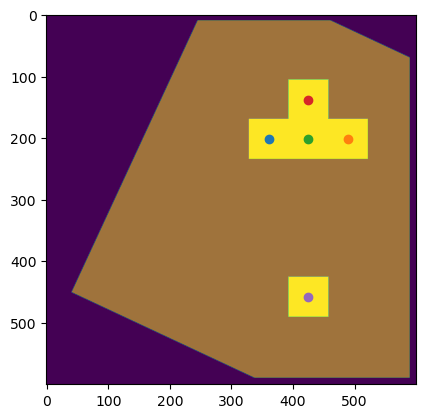

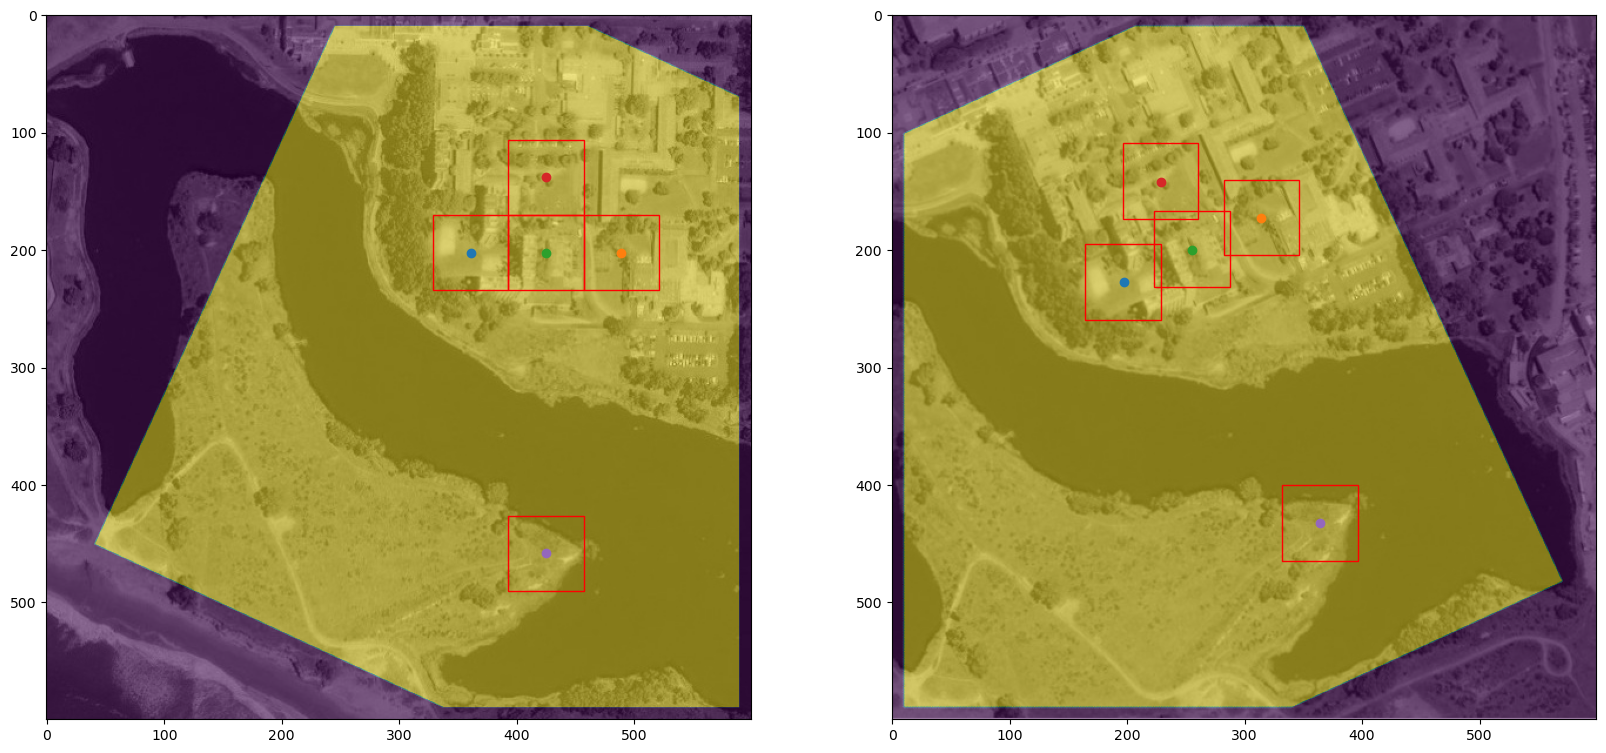

In [20]:
open_cv_kp1, desc1, open_cv_kp2, desc2 = patch_based_key_point_extraction(img1, img2, featDet,
                                                          coarse_homography,5, patch_width=64,)

In [21]:
kp1 = np.array([k.pt for k in open_cv_kp1])
kp2 = np.array([k.pt for k in open_cv_kp2])

In [22]:
desc1 = np.array(desc1)
desc2 = np.array(desc2)

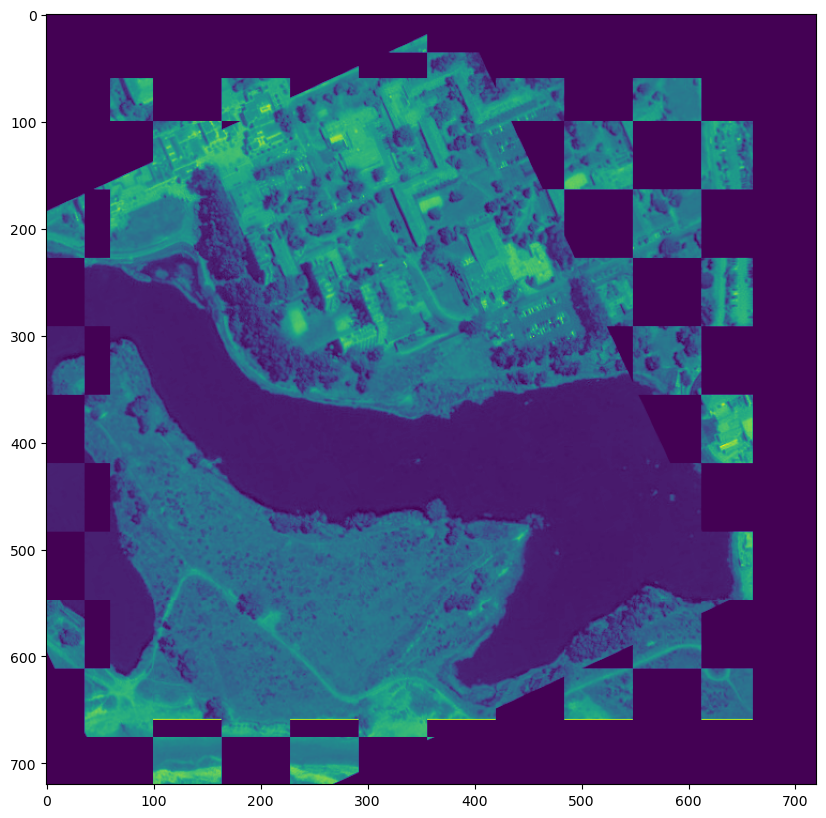

In [23]:
matches = match_descriptors(desc1, desc2)
transform, inliers = ransac(data=(kp1[matches[:, 0]], kp2[matches[:, 1]]),
                            model_class=AffineTransform, min_samples=3,
                            residual_threshold=10, max_trials=5000)

stichImages(img1[..., 0], img2[..., 0], transform.params)


In [24]:
N_red, N_all, rocc, rmse_all, forward_transformation, kps, matches, matching_error = Metrics(open_cv_kp1, desc1, open_cv_kp2, desc2,
                                                                                             transformation=AffineTransform,
                                                                                             ResidualThreshold=5,
                                                                                             max_trials=5000,)

In [25]:
N_red, N_all, rocc, rmse_all,

(15, 17, 0.8823529411764706, 0.003716110065837049)

In [26]:
x = cv2.drawMatches(img1, open_cv_kp1,img2, open_cv_kp2, matches, None)

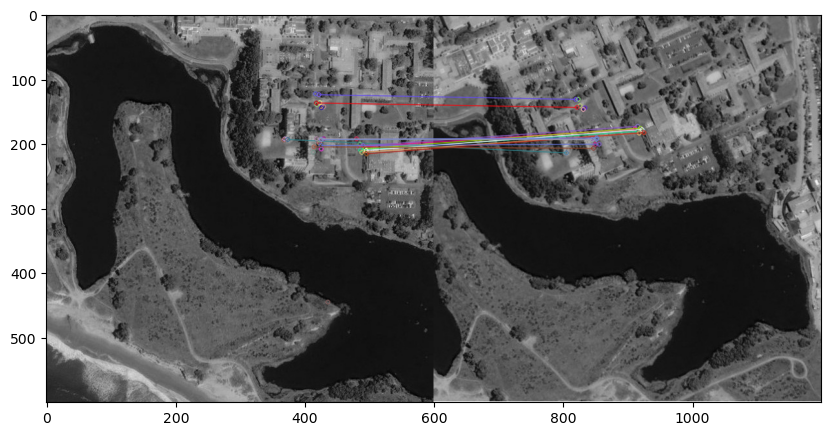

In [27]:
plt.figure(figsize=(10, 10))
plt.imshow(x)

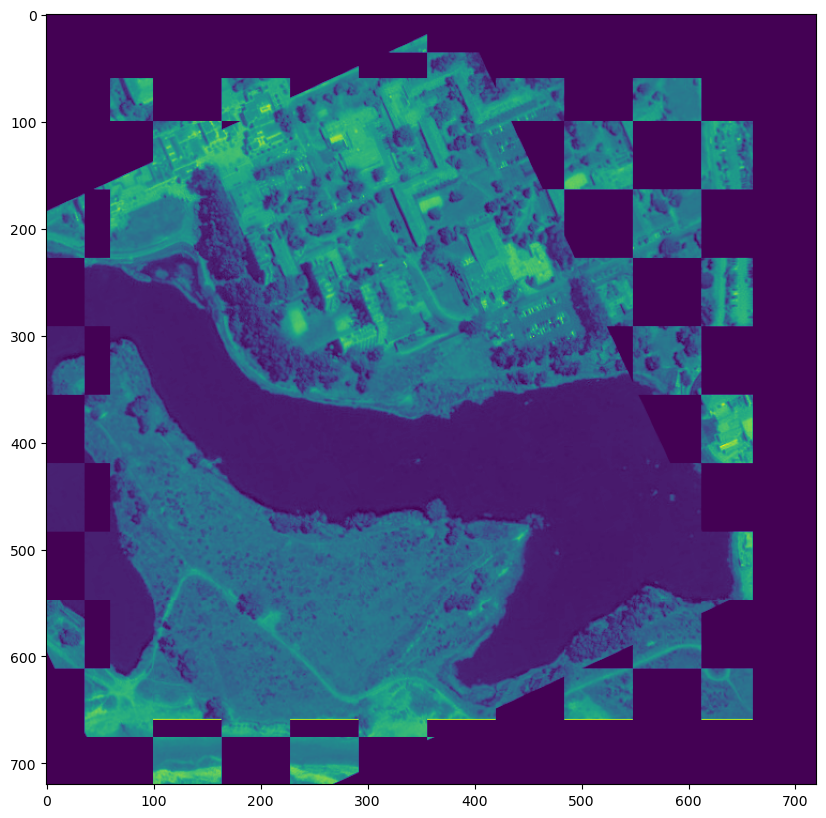

In [28]:
stichImages(img1[..., 0], img2[..., 0], forward_transformation)